In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score

import brevitas.nn as nn

from config import *
from classic_models import *
from data_preprocessing import *
from feature_extraction import *
from helpers import *

from torch.utils.data import DataLoader

Dance move: 0, Name: dummy_dance_1
Dance move: 1, Name: dummy_dance_2
Dance move: 2, Name: dummy_dance_3
Dance move: 3, Name: dummy_dance_4
Dance move: 4, Name: dummy_dance_5
Dance move: 5, Name: dummy_dance_6
Dance move: 6, Name: dummy_dance_7
Dance move: 7, Name: dummy_dance_8
Dance move: 8, Name: move_left
Dance move: 9, Name: move_right


In [2]:
df = pd.read_csv('out.csv')
df.head()

,mean_x,mean_y,mean_z,max_x,max_y,max_z,min_x,min_y,min_z,median_x,...,iqr_x,iqr_y,iqr_z,zero_crossing_counts_x,zero_crossing_counts_y,zero_crossing_counts_z,dominant_frequency_x,dominant_frequency_y,dominant_frequency_z,tag
0,12.3208,19.61,-4.04,14.470,-0.1728,7.356010,13.0675,-0.555269,8.0,0.0,...,19.61,-19.61,-4.205,0.2321,11.014407,13.9650,0.362901,28.0,0.28,1.0
1,12.4090,19.61,-1.76,13.725,0.1785,6.944948,12.7025,-0.511257,6.0,0.0,...,19.61,-19.61,-4.205,-0.1642,10.652340,14.3025,0.273621,28.0,0.28,1.0
2,12.0170,19.61,-1.76,13.065,-0.3281,6.670013,11.3150,-0.482849,6.0,0.0,...,19.61,-19.61,-3.730,0.4712,10.484271,14.0375,0.245018,27.0,0.28,1.0
3,11.1898,19.61,-1.76,12.985,-0.1299,7.002910,14.2475,-0.335542,6.0,0.0,...,19.61,-19.61,-3.680,0.3690,11.250628,14.5200,0.251294,28.0,0.28,1.0
4,10.9784,19.61,-1.76,12.555,0.6584,6.741029,12.9700,-0.347759,5.0,0.0,...,19.61,-19.61,-3.730,-0.7864,11.196545,14.5200,0.365375,27.0,0.28,1.0


In [3]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self):
        df = pd.read_csv('out.csv')
        df['tag'] = df['tag'].apply(lambda x: x-1)
        if isinstance(df, pd.DataFrame):
            df = df.to_numpy()

        self.X = df[:,:-1]
        self.y = df[:,-1]

    def __getitem__(self, idx):
        # get item by index
        return self.X[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.X)

In [4]:
dataset = FeatureDataset()

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, (train_size, test_size))
print(len(train_data), len(test_data))

1345 449


In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

In [10]:
train_loader

In [88]:
class SimpleMLP(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleMLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.input_fc = nn.QuantLinear(input_size, 256, bias=True, weight_bit_width=4)
        self.hidden_fc = nn.QuantLinear(256, 256, bias=True, weight_bit_width=4)
        self.hidden_fc_2 = nn.QuantLinear(256, 128, bias=True, weight_bit_width=4)
        self.output_fc = nn.QuantLinear(128, output_size, bias=False, weight_bit_width=4)
        
        self.relu = nn.QuantReLU(bit_width=2, max_val=4)

    def forward(self, x):
        x_1 = self.input_fc(x.float())
        h_1 = torch.nn.functional.relu(x_1)
        x_2 = self.hidden_fc(h_1)
        x_3 = self.hidden_fc_2(x_2)
        h_2 = torch.nn.functional.relu(x_3)
        y_pred = self.output_fc(h_2)
        
        return y_pred

In [12]:
model = SimpleMLP(df.shape[1]-1, len(dances))
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
learning_rate = 3e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

print(df.shape[1]-1, len(dances))

30 10


In [13]:
n_epochs = 200

for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):
        x, y = x.float(), y.long()
        outputs = model(x)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print("Epoch: {}, Loss: {:.5f}".format(epoch + 1, loss.item()))

Epoch: 10, Loss: 0.13351
Epoch: 20, Loss: 0.13356
Epoch: 30, Loss: 0.03532
Epoch: 40, Loss: 0.00651
Epoch: 50, Loss: 0.24381
Epoch: 60, Loss: 0.10216
Epoch: 70, Loss: 0.01696
Epoch: 80, Loss: 5.08520
Epoch: 90, Loss: 0.00380
Epoch: 100, Loss: 0.15512
Epoch: 110, Loss: 0.00037
Epoch: 120, Loss: 0.44478
Epoch: 130, Loss: 0.04596
Epoch: 140, Loss: 0.00338
Epoch: 150, Loss: 0.10570
Epoch: 160, Loss: 0.08229
Epoch: 170, Loss: 0.02329
Epoch: 180, Loss: 0.00117
Epoch: 190, Loss: 0.00073
Epoch: 200, Loss: 0.02591


In [14]:
model.eval()

SimpleMLP(
  (input_fc): QuantLinear(
    in_features=30, out_features=256, bias=True
    (input_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper()
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsScaling(
            (affine_rescaling): Identity()
     

In [21]:
tscv = TimeSeriesSplit()
print(np.array(np.mean(cross_val_score(model, dataset.X, dataset.y, cv=tscv))))

TypeError: estimator should be an estimator implementing 'fit' method, SimpleMLP(
  (input_fc): QuantLinear(
    in_features=30, out_features=256, bias=True
    (input_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper()
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsScaling(
            (affine_rescaling): Identity()
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (restrict_scaling_pre): Identity()
          )
        )
        (int_scaling_impl): IntScaling()
        (zero_point_impl): ZeroZeroPoint(
          (zero_point): StatelessBuffer()
        )
        (msb_clamp_bit_width_impl): BitWidthConst(
          (bit_width): StatelessBuffer()
        )
      )
    )
    (bias_quant): BiasQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
  )
  (hidden_fc): QuantLinear(
    in_features=256, out_features=256, bias=True
    (input_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper()
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsScaling(
            (affine_rescaling): Identity()
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (restrict_scaling_pre): Identity()
          )
        )
        (int_scaling_impl): IntScaling()
        (zero_point_impl): ZeroZeroPoint(
          (zero_point): StatelessBuffer()
        )
        (msb_clamp_bit_width_impl): BitWidthConst(
          (bit_width): StatelessBuffer()
        )
      )
    )
    (bias_quant): BiasQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
  )
  (hidden_fc_2): QuantLinear(
    in_features=256, out_features=128, bias=True
    (input_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper()
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsScaling(
            (affine_rescaling): Identity()
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (restrict_scaling_pre): Identity()
          )
        )
        (int_scaling_impl): IntScaling()
        (zero_point_impl): ZeroZeroPoint(
          (zero_point): StatelessBuffer()
        )
        (msb_clamp_bit_width_impl): BitWidthConst(
          (bit_width): StatelessBuffer()
        )
      )
    )
    (bias_quant): BiasQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
  )
  (output_fc): QuantLinear(
    in_features=128, out_features=10, bias=False
    (input_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper()
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsScaling(
            (affine_rescaling): Identity()
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (restrict_scaling_pre): Identity()
          )
        )
        (int_scaling_impl): IntScaling()
        (zero_point_impl): ZeroZeroPoint(
          (zero_point): StatelessBuffer()
        )
        (msb_clamp_bit_width_impl): BitWidthConst(
          (bit_width): StatelessBuffer()
        )
      )
    )
    (bias_quant): BiasQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
  )
  (relu): QuantReLU(
    (input_quant): IdentityQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): ReLU()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ParameterFromRuntimeStatsScaling(
            (stats_input_view_shape_impl): OverTensorView()
            (stats): _Stats(
              (stats_impl): AbsPercentile()
            )
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (restrict_inplace_preprocess): Identity()
          )
          (int_scaling_impl): IntScaling()
          (zero_point_impl): ZeroZeroPoint(
            (zero_point): StatelessBuffer()
          )
          (msb_clamp_bit_width_impl): BitWidthConst(
            (bit_width): StatelessBuffer()
          )
        )
      )
    )
  )
) was passed

In [11]:
y_true, y_pred, y_prob  = [], [], []

tscv = TimeSeriesSplit()

with torch.no_grad():
    for train_index, test_index in tscv.split(X):
    # for x, y in test_loader:
        y = 
        y = list(y.numpy())
        y_true += y

        x = x.float()
        outputs = model(x)

        # predicted label
        _, predicted = torch.max(outputs.data, 1)
        predicted = list(predicted.cpu().numpy())
        y_pred += predicted

        # probability for each label
        prob = list(outputs.cpu().numpy())
        y_prob += prob

In [12]:
# calculating overall accuracy
num_correct = 0

for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        num_correct += 1

print("Accuracy: ", num_correct/len(y_true))

Accuracy:  0.9665924276169265


In [27]:
import numpy as np
import torch
import time
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

class TwoLayerMLP(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(TwoLayerMLP, self).__init__()
        self.d_in = d_in

        self.linear1 = nn.QuantLinear(d_in, d_hidden, bias=True, weight_bit_width=4)
        self.linear2 = nn.QuantLinear(d_hidden, d_out, bias=True, weight_bit_width=4)

    def forward(self, X):
        X = X.view(-1, self.d_in)
        X = self.linear1(X.float())
        X = self.linear2(X)
        return torch.nn.functional.log_softmax(X, dim=1)
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        
        self.eval()
    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [130]:
class SimpleMLP(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleMLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.input_fc = nn.QuantLinear(input_size, 256, bias=True, weight_bit_width=4)
        self.hidden_fc = nn.QuantLinear(256, 256, bias=True, weight_bit_width=4)
        self.hidden_fc_2 = nn.QuantLinear(256, 128, bias=True, weight_bit_width=4)
        self.output_fc = nn.QuantLinear(128, output_size, bias=False, weight_bit_width=4)
        
        self.relu = nn.QuantReLU(bit_width=2, max_val=4)

    def forward(self, x):
        x_1 = self.input_fc(x.float())
        h_1 = torch.nn.functional.relu(x_1)
        x_2 = self.hidden_fc(h_1)
        x_3 = self.hidden_fc_2(x_2)
        h_2 = torch.nn.functional.relu(x_3)
        y_pred = self.output_fc(h_2)
        
        return y_pred

In [29]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

In [182]:
def train(network, epochs, save_Model = False):
    total_acc = 0
    kfold = KFold(n_splits=5)
    for fold, (train_index, test_index) in enumerate(kfold.split(x_train, y_train)):
        ### Dividing data into folds
        x_train_fold = x_train[train_index]
        x_test_fold = x_train[test_index]
        y_train_fold = y_train[train_index]
        y_test_fold = y_train[test_index]

        train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        test = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)
        train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
        test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

        for epoch in range(epochs):
            print('\nEpoch {} / {} \nFold number {} / {}'.format(epoch + 1, epochs, fold + 1 , kfold.get_n_splits()))
            correct = 0
            network.train()
            for batch_index, (x_batch, y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                out = network(x_batch)
                loss = loss_f(out, y_batch)
                loss.backward()
                optimizer.step()
                pred = torch.max(out.data, dim=1)[1]
                correct += (pred == y_batch).sum()
                if (batch_index + 1) % 32 == 0:
                    print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                        (batch_index + 1)*len(x_batch), len(train_loader.dataset),
                        100.*batch_index / len(train_loader), loss.data, float(correct*100) / float(batch_size*(batch_index+1))))
        total_acc += float(correct*100) / float(batch_size*(batch_index+1))
    total_acc = (total_acc / kfold.get_n_splits())
    print('\n\nTotal accuracy cross validation: {:.3f}%'.format(total_acc))

False
torch.Size([50, 30])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])
Total number of parameters = 2060
Epoch 0/19
----------
train Loss: 2.1363 Acc: 27.14%
val Loss: 1.3091 Acc: 53.01%

Epoch 1/19
----------
train Loss: 1.1823 Acc: 62.08%
val Loss: 0.9475 Acc: 77.51%

Epoch 2/19
----------
train Loss: 0.8990 Acc: 80.59%
val Loss: 0.7804 Acc: 79.29%

Epoch 3/19
----------
train Loss: 0.7422 Acc: 85.28%
val Loss: 0.6002 Acc: 90.65%

Epoch 4/19
----------
train Loss: 0.6220 Acc: 90.11%
val Loss: 0.5368 Acc: 90.87%

Epoch 5/19
----------
train Loss: 0.5559 Acc: 90.26%
val Loss: 0.4805 Acc: 90.65%

Epoch 6/19
----------
train Loss: 0.5134 Acc: 90.26%
val Loss: 0.4420 Acc: 91.76%

Epoch 7/19
----------
train Loss: 0.4712 Acc: 91.23%
val Loss: 0.4121 Acc: 91.98%

Epoch 8/19
----------
train Loss: 0.4407 Acc: 91.15%
val Loss: 0.3934 Acc: 92.65%

Epoch 9/19
----------
train Loss: 0.4178 Acc: 90.56%
val Loss: 0.3674 Acc: 92.43%

Epoch 10/19
----------
train Loss: 0.3956 Acc: 90.78%


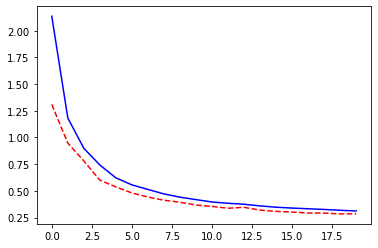

In [132]:
D_in = df.shape[1]-1
D_out = len(dances)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

dataloaders = dict(train=train_loader, val=test_loader)

model = TwoLayerMLP(D_in, 50, D_out)
print(next(model.parameters()).is_cuda)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = torch.nn.NLLLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=20, log_interval=1)

print(next(model.parameters()).is_cuda)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
# torch.save(model.state_dict(), 'models/mod-%s.pth' % model.__class__.__name__)

In [25]:
class TwoLayerMLP(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(TwoLayerMLP, self).__init__()
        self.d_in = d_in

        self.linear1 = nn.QuantLinear(d_in, d_hidden, bias=True, weight_bit_width=4)
        self.linear2 = nn.QuantLinear(d_hidden, d_out, bias=True, weight_bit_width=4)

    def forward(self, X):
        X = X.view(-1, self.d_in)
        X = self.linear1(X.float())
        X = self.linear2(X)
        return torch.nn.functional.log_softmax(X, dim=1)
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        
        self.eval()
    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

False
torch.Size([50, 30])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])
Total number of parameters = 2060
Epoch 0/19
----------
train Loss: 2.0427 Acc: 32.34%
val Loss: 2.1297 Acc: 29.84%

Epoch 1/19
----------
train Loss: 1.2935 Acc: 56.28%
val Loss: 0.9693 Acc: 68.60%

Epoch 2/19
----------
train Loss: 0.8991 Acc: 71.97%
val Loss: 0.8223 Acc: 74.39%

Epoch 3/19
----------
train Loss: 0.7732 Acc: 78.22%
val Loss: 0.7176 Acc: 81.07%

Epoch 4/19
----------
train Loss: 0.6688 Acc: 84.76%
val Loss: 0.6243 Acc: 87.97%

Epoch 5/19
----------
train Loss: 0.5844 Acc: 88.77%
val Loss: 0.5678 Acc: 89.31%

Epoch 6/19
----------
train Loss: 0.5454 Acc: 88.55%
val Loss: 0.5210 Acc: 91.31%

Epoch 7/19
----------
train Loss: 0.4920 Acc: 90.33%
val Loss: 0.4831 Acc: 91.76%

Epoch 8/19
----------
train Loss: 0.4654 Acc: 91.08%
val Loss: 0.4583 Acc: 91.76%

Epoch 9/19
----------
train Loss: 0.4384 Acc: 90.78%
val Loss: 0.4289 Acc: 92.87%

Epoch 10/19
----------
train Loss: 0.4133 Acc: 91.60%


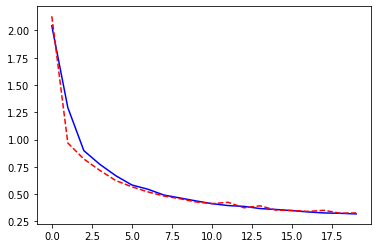

In [30]:
D_in = df.shape[1]-1
D_out = len(dances)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

dataloaders = dict(train=train_loader, val=test_loader)

model = TwoLayerMLP(D_in, 50, D_out)
print(next(model.parameters()).is_cuda)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = torch.nn.NLLLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=20, log_interval=1)

print(next(model.parameters()).is_cuda)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
# torch.save(model.state_dict(), 'models/mod-%s.pth' % model.__class__.__name__)

Epoch 0/9
----------
train Loss: 0.2336 Acc: 92.86%
val Loss: 0.2092 Acc: 94.43%

Epoch 2/9
----------
train Loss: 0.2107 Acc: 93.61%
val Loss: 0.1968 Acc: 94.43%

Epoch 4/9
----------
train Loss: 0.1908 Acc: 94.20%
val Loss: 0.1870 Acc: 93.76%

Epoch 6/9
----------
train Loss: 0.1844 Acc: 94.65%
val Loss: 0.1709 Acc: 94.43%

Epoch 8/9
----------
train Loss: 0.1868 Acc: 93.98%
val Loss: 0.1697 Acc: 95.10%

Training complete in 0m 1s
Best val Acc: 95.10%


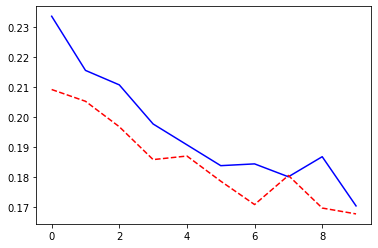

In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=10, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [133]:
torch.save(model.state_dict(), 'MLP_Model')

In [165]:
mlp_model = TwoLayerMLP(D_in, 50, D_out)
mlp_model.load('MLP_Model')
# mlp_model.eval()

to_predict = 3

output = mlp_model.predict(torch.from_numpy(np.array(df[df['tag'] < to_predict+1])[:,:-1]))
proba_dict = {}

for x in output:
    x = int(x)
    if x not in proba_dict:
        proba_dict[x] = 1
    else:
        proba_dict[x] += 1
print(proba_dict)
for k in proba_dict.keys():
    proba_dict[k] /= len(output)
    
proba_dict


{0: 173, 3: 8, 2: 180, 1: 179}


{0: 0.32037037037037036,
 3: 0.014814814814814815,
 2: 0.3333333333333333,
 1: 0.3314814814814815}

## CNN

In [80]:
import numpy
import torch

X = numpy.random.uniform(-10, 10, 70).reshape(1, 7, -1)
# Y = np.random.randint(0, 9, 10).reshape(1, 1, -1)

class Simple1DCNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Simple1DCNN, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels=7, out_channels=20, kernel_size=5, stride=2)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=20, out_channels=10, kernel_size=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)

        log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return log_probs

model = Simple1DCNN().double()
print(model(torch.tensor(X)).shape)

torch.Size([1, 10, 3])


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [24]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=100):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size)

        self.linear = torch.nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1).float(), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
D_in = df.shape[1]-1
D_out = len(dances)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

dataloaders = dict(train=train_loader, val=test_loader)

print(dataloaders.items())
model = LSTM(D_in, D_out)
loss_function = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 150

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

kfold = KFold(n_splits=5)

X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.33, random_state=42)

for fold, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    ### Dividing data into folds
    x_train_fold = X_train[train_index]
    x_test_fold = X_train[test_index]
    y_train_fold = y_train[train_index]
    y_test_fold = y_train[test_index]
    
    print(len(train_index), len(test_index))

    train = torch.utils.data.TensorDataset(torch.tensor(x_train_fold), torch.tensor(y_train_fold))
    test = torch.utils.data.TensorDataset(torch.tensor(x_test_fold), torch.tensor(y_test_fold))
    train_loader = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = False)
    
    for i in range(epochs):
        print('\nEpoch {} / {} \nFold number {} / {}'.format(i + 1, epochs, fold + 1 , kfold.get_n_splits()))
        correct = 0
        model.train()
        for batch_index, (x_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(x_batch)
            
            y_pred = y_pred.reshape(len(y_pred), 1)
            
            print(y_pred, y_batch)

            single_loss = loss_function(y_pred, y_batch.long())
            single_loss.backward()
            optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

dict_items([('train', <torch.utils.data.dataloader.DataLoader object at 0x000002CF11546608>), ('val', <torch.utils.data.dataloader.DataLoader object at 0x000002CF17867188>)])
torch.Size([400, 30])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])
Total number of parameters = 53810
960 241

Epoch 1 / 150 
Fold number 1 / 5
tensor([[ 0.2939],
        [-0.2470],
        [ 0.1055],
        [-0.0956],
        [ 0.1541],
        [-0.0700],
        [ 0.1111],
        [-0.0792],
        [-0.2696],
        [-0.2655]], grad_fn=<ViewBackward>) tensor([5., 0., 5., 8., 7., 4., 4., 2., 5., 7.], dtype=torch.float64)


IndexError: Target 5 is out of bounds.

In [196]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

NameError: name 'train_data_normalized' is not defined

In [ ]:
D_in = df.shape[1]-1
D_out = len(dances)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

dataloaders = dict(train=train_loader, val=test_loader)

model = TwoLayerMLP(D_in, 50, D_out)
print(next(model.parameters()).is_cuda)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.NLLLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=20, log_interval=1)

print(next(model.parameters()).is_cuda)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
# torch.save(model.state_dict(), 'models/mod-%s.pth' % model.__class__.__name__)

## Bidirectional LSTM

In [13]:
class BiDirectional_LSTM(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleMLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.input_fc = nn.QuantLinear(input_size, 256, bias=True)
        self.hidden_fc = nn.QuantLinear(256, 128, bias=True)
        self.output_fc = nn.QuantLinear(128, output_size, bias=True)
        self.lstm = eval('nn.' + rnn_type)(
            self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=True
        )        
        self.relu = nn.QuantReLU()

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, x):
        x_1 = self.input_fc(x)
        h_1 = torch.nn.functional.relu(self.input_fc(x))
        x_2 = self.hidden_fc(h_1)
        h_2 = torch.nn.functional.relu(x_2)
        # Forward pass through LSTM layer
        # shape of lstm_out: [batch_size, input_size ,hidden_dim]
        # shape of self.hidden: (a, b), where a and b both
        # have shape (batch_size, num_layers, hidden_dim).
        lstm_out, self.hidden = self.lstm(h_2)

        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.output_fc(lstm_out)
        return y_pred

In [14]:
# kfold = KFold(n_splits=5)

In [15]:
# for train_index, test_index in kfold.split(X_train, y_train):  
#     x_train_fold = X_train[train_index] 
#     y_train_fold = y_train[train_index] 
#     x_test_fold = X_train[test_index] 
#     y_test_fold = y_train[test_index] 

#     print(x_train_fold.shape, y_train_fold.shape) 
#     print(x_test_fold.shape, y_test_fold.shape) 
#     break 